# Cluster Analysis

Here, we cluster the results of the LitAI model to see common groupings

In [1]:
# operate in project root directory

from os import chdir
import sys

# set path to allow module import
project_root = '/home/mike/litai'
if project_root not in sys.path:
    sys.path.append(project_root)

# operate in project root directory
chdir(project_root)

In [2]:
# pull positive articles

from litai import SearchEngine


# initialize engine
engine = SearchEngine()

# load in positive articles
pos_pmids = open('data/senescence_pmids.txt', 'r').read().splitlines()
articles = engine.search(pmids=pos_pmids, limit=None)
num_articles = articles.shape[0]

# show head
articles.head()

,PMID,Date,Title,Abstract,Keywords
0,30976985,2020-03-01,Age estimation based on different molecular cl...,Several molecular modifications accumulate in ...,Age estimation Age prediction model D-Aspartic...
1,23628372,2013-07-01,Role of oxytocin in energy metabolism.,The basic mechanisms that lead obesity are not...,
2,28111015,2017-02-02,Single-Molecule Analysis of mtDNA Replication ...,Mutations in mtDNA lead to muscular and neurol...,common deletion microhomology-mediated end joi...
3,25124333,2014-08-13,Association of G-quadruplex forming sequences ...,The potential for GQ to influence mitochondria...,
4,29274747,2018-05-01,More highly myelinated white matter tracts are...,The objective of this study was to investigate...,Ageing Myelin Processing speed T1w/T2w White m...


In [3]:
# pull negative articles, to train tokenizer
neg_articles = engine.search(limit=3*num_articles)

# show head
neg_articles.head()

,PMID,Date,Title,Abstract,Keywords
0,34448718,2021-08-27,Lateralization and Bodily Patterns of Segmenta...,This study underlines the usefulness of includ...,chest pain clinical examination differential d...
1,25619770,2015-02-21,Colloidal nanocrystals of orthorhombic Cu2ZnGe...,The orthorhombic polymorph of Cu2ZnGeS4 (CZGS)...,
2,35245768,2022-04-01,Radioactive risk assessment of beach sand alon...,Beach sand includes various levels of natural ...,Beach sand Building materials Gamma radiation ...
3,24497740,2014-01-01,Comparative assessment on in vitro antioxidant...,Our study suggests that G. sylvestre has signi...,Antioxidant G. sylvestre ethanolic extract fre...
4,25688146,2015-03-17,Doing the right things and doing them the righ...,Guideline adherence and dosing safety appeared...,acute coronary syndrome myocardial infarction ...


In [4]:
# Transform articles to feature space

from numpy import concatenate, ones, zeros
from pandas import concat
from vhash import VHash

from litai.model import TokenRegressor


# combine data for tokenizer
X = TokenRegressor._get_text(
    concat(
        (
            articles,
            neg_articles,
        )
    )
)
y = concatenate(
    (
        ones(len(articles)),
        zeros(len(neg_articles)),
    )
)

# tokenize
vhash = VHash().fit(X, y)
tokenized = vhash.transform(
    TokenRegressor._get_text(
        articles
    )
)

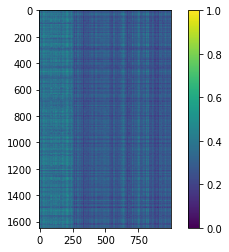

In [5]:
# show tokenized
# we expect this to look like a bunch of high-value columns (which are the latent space corresponding to the positive article projections) and a bunch of low-value columns (which correspond to the negative article projections)


from matplotlib import pyplot

pyplot.imshow(tokenized)
pyplot.colorbar()

In [7]:
# now, let's cluster the positive articles
# we're going to use recursive hierarchical clustering, with a minimum and maximum group size

from typing import Any

from nptyping import NDArray
from numpy import argmax
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


class Clusterer:
    """Recursive Hierarchical Clustering

    Silhouette scores are used to determine the optimal number of clusters, and
    groups are recursively subdivided if they exceed a maximum group size
    
    Parameters
    ----------
    max_clusters: int, optional, default=10
        maximum number of clusters for any individual (non-hierarchical)
        clustering. The total number of output clusters can exceed this.
    max_size: float, optional, default=0.25
        maximum cluster size, as fraction of training data
    """
    def __init__(
        self,
        /,
        *,
        max_clusters: int = 10,
        max_size: float = 0.25,
    ):
        self._max_clusters = max_clusters
        self._max_size = max_size
    
    def fit_predict(
        self,
        /,
        X: NDArray[(Any, Any), float],
        y: Any = None,
    ) -> NDArray[(Any,), int]:
        """Fit model

        Parameters
        ----------
        X: 2D float NDArray
            training data
        y: Any
            ignored; supplied for sklearn-API consistency
        
        Returns
        -------
        1D int NDArray
            clusters for X
        """

        # get initial clusters
        clusters = self._cluster(X)

        # recursively subdivide
        cluster_num = 0
        while cluster_num <= clusters.max():

            # check if small enough group
            in_cluster = clusters == cluster_num
            if in_cluster.mean() <= self._max_size:
                cluster_num += 1
                continue

            # subdivide
            sub_clusters = self._cluster(X[in_cluster, :])

            # translate results
            clusters[clusters > cluster_num] += sub_clusters.max()
            clusters[in_cluster] += sub_clusters
        
        # return results
        return clusters

    def _cluster(
        self,
        /,
        X: NDArray[(Any, Any), float],
    ) -> NDArray[(Any,), int]:
        """Cluster data using kmeans + silhouette scoring

        Parameters
        ----------
        X: 2D float NDArray
            training data
        
        Returns
        -------
        1D int NDArray
            clusters for X
        """
        clusters = [
            KMeans(n_clusters=n).fit_predict(X)
            for n in range(2, self._max_clusters)
        ]
        scores = [
            silhouette_score(X, cluster)
            for cluster in clusters
        ]
        return clusters[argmax(scores)]

clusters = Clusterer().fit_predict(tokenized)

In [8]:
# show top keywords for each cluster
from collections import Counter

from numpy import argsort, array, concatenate


for cluster_num in range(clusters.max() + 1):
    
    # get articles in cluster
    in_cluster = clusters == cluster_num
    
    # get keywords and counts
    keywords = Counter(concatenate([
        article.split()
        for article in articles['Keywords'][in_cluster]
    ]))

    # get most common keywords
    order = argsort(list(keywords.values()))[::-1]
    common = array(list(keywords.keys()))[order][0: 10]
    print(f'Cluster {cluster_num}:', common)

Cluster 0: ['cells' 'stem' 'aging' 'cell' 'senescence' 'disease' 'degeneration'
 'medicine' 'retinal' 'pigment']
Cluster 1: ['disease' 'Alzheimer’s' 'aging' 'Aging' "Alzheimer's" 'Amyloid' 'skin'
 'imaging' 'amyloid' 'glycation']
Cluster 2: ['disease' 'aging' 'Aging' 'DNA' 'Alzheimer’s' "Alzheimer's" 'amyloid'
 'matter' 'Dementia' 'age']
Cluster 3: ['aging' 'DNA' 'methylation' 'disease' 'Aging' 'muscle' 'protein' 'stress'
 'cell' 'memory']
Cluster 4: ['disease' 'Alzheimer’s' 'amyloid' 'protein' 'Parkinson’s' 'DNA'
 'Mitochondrial' "Alzheimer's" 'tau' 'mitochondria']
Cluster 5: ['aging' 'cells' 'cell' 'senescence' 'stem' 'Aging' 'T' 'muscle'
 'Senescence' 'mitochondria']
Cluster 6: ['cell' 'senescence' 'cells' 'ALT' 'telomeres' 'protein' 'stem' 'aging'
 'of' 'telomere']
Cluster 7: ['cell' 'stem' 'cells' 'senescence' 'hematopoietic' 'mitochondria'
 'mitochondrial' 'human' 'autophagy' 'telomerase']


So there's definitely a lot of overlap -- which is expected -- but there are definitely also distinct groups showing up.

Let's visualize these clusters

In [15]:
# get coordinates in dissimilarity space
from sklearn.manifold import MDS
from sklearn.neural_network import MLPRegressor


# get centers of clusters
centers = [
    tokenized[clusters == cluster_num, :].mean(axis=0)
    for cluster_num in range(clusters.max() + 1)
]

# project centers to 2D space
center_coords = MDS(dissimilarity='euclidean').fit_transform(centers)

# train ANN to project to 2D Space
mlp = MLPRegressor(tol=1E-9).fit(tokenized, center_coords[clusters])
coords = mlp.predict(tokenized)

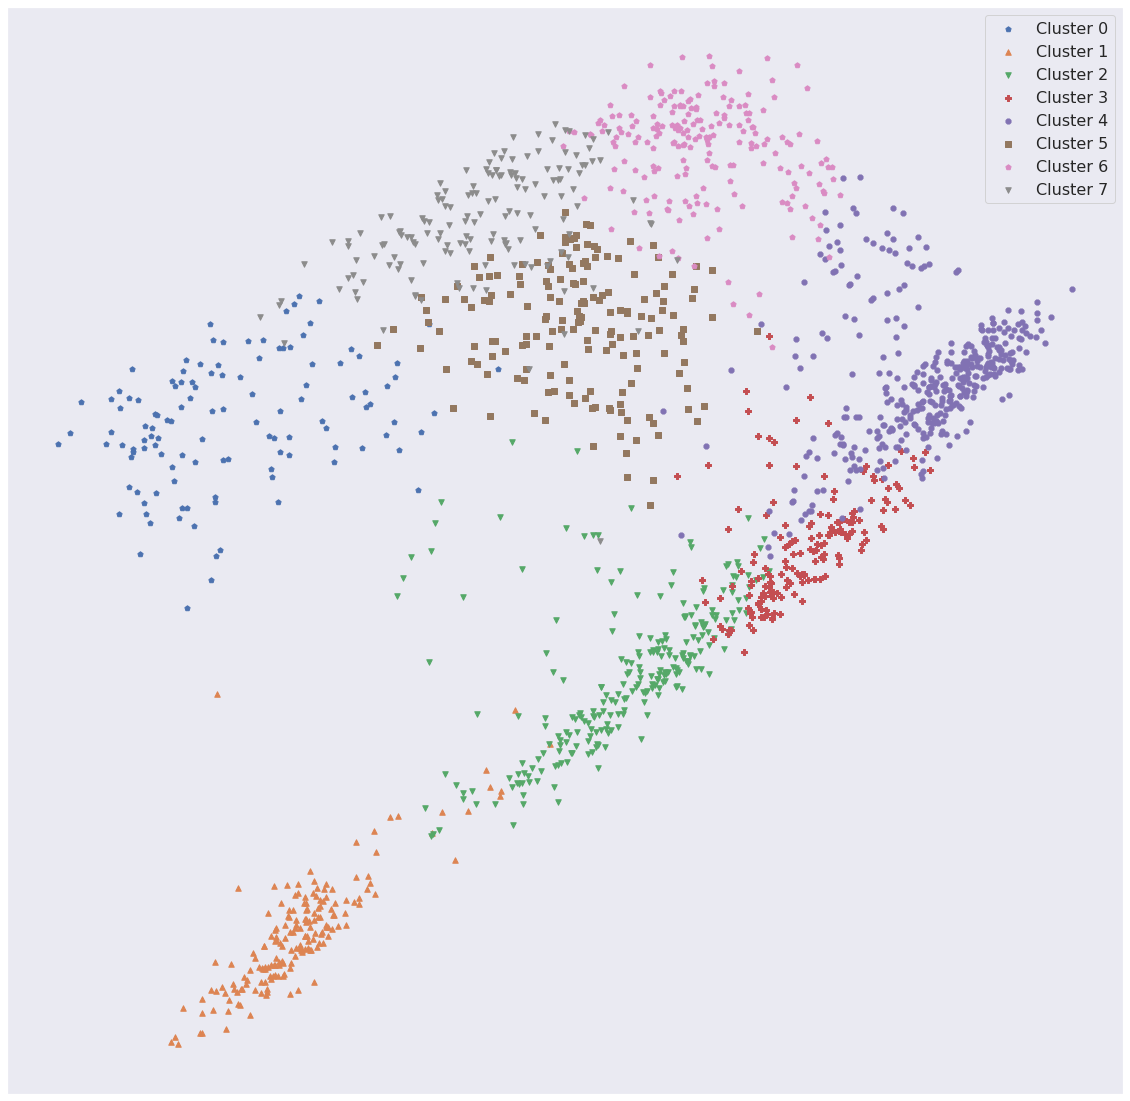

In [16]:
# plot clusters

from random import choice

from matplotlib import pyplot
import seaborn


# make pretty
seaborn.set_theme()

# create figure
fig, ax = pyplot.subplots(1, 1, figsize=(20, 20))

# plot clusters
for cluster_num in range(clusters.max() + 1):
    in_cluster = clusters == cluster_num
    x = coords[in_cluster, 0]
    y = coords[in_cluster, 1]
    ax.scatter(
        x,
        y,
        s=30,
        label=f'Cluster {cluster_num}',
        marker=choice(['o', 'v', '^', '8', 's', 'P', 'p', 'x']),
    )

# add legend
ax.legend(fontsize=16)

# hide axis labels (not meaningful)
ax.set_xticks([])
ax.set_yticks([])

# show figure
pyplot.show(fig)